<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/Tutorials/W6_Tutorial2_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 6 Part 2
# Convolutional Neural Networks 

__Instructor__: Konrad Kording

__Content creators:__ Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava


---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- understand how CNN's work end to end
- write functions to train and test Deep Leaning models in PyTorch
- identify the various broad uses of Convnets 
 

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)

my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']

---
# Setup


[Here](https://drive.google.com/file/d/1okbxJdaKwi1klnkSkrYoBriDmng_wk0q/view?usp=sharing) are the slides for today's videos (in case you want to take notes). **Do not read them now.**

In [ ]:
#@title Installations
# Install Kipoi model zoo dependencies for use in genomics section
# Kipoi is a library that will be used to install and run the DeepSEA model later in the notebook
%%capture
!pip install -q pyYaml>=5.1
!pip install -q kipoi
!pip install -q kipoiseq pybedtools

In [ ]:
# imports
import random
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt
import kipoi

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

In [ ]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


---
# Section 1: Recap

In the last tutorial we looked at, 
- how convolution operation works
- significance of Convolutions
- maxpooling and its use
- and you built you're first CNN!

<br>

*Estimated Completion Time: 12 mins from start of the session*

In [ ]:
#@title Video: Discussing Week 6 T1
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="aVmjxdOthzs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [ ]:
# @markdown ## Exercise 1
# @markdown What will be the output dimension of a single 2D convolution operation on: input of size 300 x 400, a kernel of size (4, 5), stride = 1,  padding = 2 ?
output_dim = '' #@param {type:"string"}

In [ ]:
#@title Video: Parameters and Getting a feel of the Dataset

video = YouTubeVideo(id="H4SErtYD3qM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Section 2: Training a CNN

In this section, we will walk you guys through an example of training a convolution net. In the beginning, we will train a CNN simply using convolution layers and maxpool and then observe what the training and validation curves look like. After that, we will add regularization and data augmentation to see what effects they have on the curves and why it is important to incorporate them while training our network.
<br>
*Estimated Completion Time: 85 mins from start of the session*

## 2.1 Understand the Dataset

The dataset we are going to use for this task is called Fashion-MNIST. It consists of a training set of 60,000 examples and a test set of 10,000 examples. We further divide the test set into a validation set and a test set (8000 and 2000 resp). Each example is a 28*28 gray scale image, associated with a label from 10 classes. Following are the labels of the dataset:

0 T-shirt/top <br>
1 Trouser <br>
2 Pullover <br>
3 Dress <br>
4 Coat <br> 
5 Sandal <br>
6 Shirt <br> 
7 Sneaker <br> 
8 Bag <br> 
9 Ankle boot <br> 

In [ ]:
# @title Utils
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# @title Getting Fashion-Mnist Data
# need to split into train, validation, test 
def get_fashion_mnist_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    train_data = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
    
    test_data = datasets.FashionMNIST(root='./data',  download=True, train=False, transform=transform)

    validation_data, test_data = torch.utils.data.random_split(test_data, [8000, 2000])

    return train_data, validation_data, test_data

train_data, validation_data, test_data = get_fashion_mnist_dataset()

In [ ]:
# @title Getting the DataLoaders
def get_data_loaders(train_dataset, validation_dataset, test_dataset, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    
    return train_loader, validation_loader, test_loader

train_loader, validation_loader, test_loader = get_data_loaders(train_data, validation_data, test_data)

Here's some code to visualize the dataset.

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

## 2.2 Training Loop

In [ ]:
#@title Video: Train Loop
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="StTv7aGCDf0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

At the end of T1, you coded the structure of a CNN. Now, you are going to implement the training loop for a CNN. 
- Choose the correct criterion 
- Code up the training part (calculating gradients, loss, stepping forward)
- Keep a track of the running loss i.e for each epoch we want to to know the average loss of the batch size. We have already done the same for accuracy for you. 



## Exercise 2.1 Code the Training Loop

In [ ]:
# @title Running model on Test Data Function (run me)

# just returns accuracy on test data
def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [ ]:
# @title Plotting (run me)

# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


In [ ]:
# This cell contains the code for the CNN we will be using in this section.
class FMNIST_Net1(nn.Module):
    def __init__(self):
        super(FMNIST_Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
       
        return x

In [ ]:
def train(model, device, train_loader, validation_loader, epochs):
    
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the loss function")
    ####################################################################
    criterion = ...
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01, momentum=0.9)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        # keeps track of the running loss
        running_loss = 0.

        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)

                # COMPLETE CODE FOR TRAINING LOOOP
                # 1. Get the model output
                # 2. Zero the gradients out
                # 3. Get the Loss
                # 4. Calculate the gradients
                # 5. Update the weights
                
                ####################################################################
                # Fill in missing code below (...),
                # then remove or comment the line below to test your function
                raise NotImplementedError("Update the set_postfix function")
                ####################################################################

                
                # set loss to whatever you end up naming your variable when 
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepoch.set_postfix(loss=...)
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Append the train_loss")
        ####################################################################
        train_loss.append(...)  # append the loss for this epoch
        train_acc.append(correct/total)
                
        # evaluate on validation data
        
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc 

The next cell contains the code for the CNN we will be using in this section.

In [ ]:
net = FMNIST_Net1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, validation_loader, 20)

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W6_ConvNets/solutions/W6_Tutorial2_Solution_Ex21.py)

*Example output:*  

<img alt='Solution hint 2.1' align='left' width=720 height=360 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W6_ConvNets/static/W6_Tutorial2_Solution_Ex21.png />



Run the next cell to get the accuracy on the data!

In [ ]:
test(net, device, test_loader)

In [ ]:
#@markdown Q. Do you think this network is overfitting? What can you do to combat this?
overfitting = '' #@param {type:"string"}


## 2.3: Regularization

 

In [ ]:
#@title Video: Dropout
try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="V2XwxhZ1SeU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

So you spent week 5 learning a bunch of regularization techniques. We have copied over the above CNN model and we want you to add some regularization methods into this network and to check if that helps reduce the overfitting problem. You can try methods other than dropout as well.

## Exercise 2.2: Adding Regularization

In [ ]:
# add various regularization methods, feel free to add any and play around! 
class FMNIST_Net2(nn.Module):
    def __init__(self):
        super(FMNIST_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Add regularization layers")
        ####################################################################
        self.dropout1 = ...
        self.dropout2 = ...
        self.batch_norm1 = ...
        self.batch_norm2 = ...

    def forward(self, x):
        ####################################################################
        # Now add the layers in your forward pass in appropriate order
        # then remove or comment the line below to test your function
        raise NotImplementedError("Add regularization in the forward pass")
        ####################################################################
        x = self.conv1(x)
        x = ...
       
        return x

In [ ]:
net2 = FMNIST_Net2().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net2, device, train_loader, validation_loader, 20)

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W6_ConvNets/solutions/W6_Tutorial2_Solution_Ex22.py)

*Example output:*  

<img alt='Solution hint 2.2' align='left' width=720 height=360 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W6_ConvNets/static/W6_Tutorial2_Solution_Ex22.png />


In [ ]:
test(net2, device, test_loader)

In [ ]:
#@markdown Is the training accuracy slighly reduced from before adding regularization? What point were you able to reduce it till?
regularize_1 = '' #@param {type:"string"}

In [ ]:
#@markdown Why does the validation accuracy start higher than training accuracy?
regularize_2 = '' #@param {type:"string"}

## 2.4: Data Augmentation



In [ ]:
#@title Video: Data Augmentation
try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="464k_nu-YPo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise: 2.3

One of the final things you learnt in week 5 was how data augmentation can also be used for regularization. Let us now add that to our model via transforms and see if that helps our model generalize better! In the following cell, add the transforms you want in the list augmentation_transforms. We will then run the same network you created in the above exercise (with regularization) and then plot the loss and accuracies.

Here's the link to the list of transforms available in pytorch: https://pytorch.org/docs/stable/torchvision/transforms.html

Note: In the video, Prof. Kording mentioned that you should modify the train loop. There is no need to modify the train loop, just fill in the function below.

In [ ]:
def get_augmentation_transforms():
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Add Transforms")
    ####################################################################
    augmentation_trasnforms = [...]

    return augmentation_transforms 

In [ ]:
augmentation_transforms = get_augmentation_transforms()

In [ ]:
preprocessing_transforms = [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]
train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
train_data = datasets.FashionMNIST(root='./data', download=True, train=True, transform=train_transform)
train_loader, validation_loader, test_loader = get_data_loaders(train_data, validation_data, test_data)
net3 = FMNIST_Net2().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net3, device, train_loader, validation_loader, 20)

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W6_ConvNets/solutions/W6_Tutorial2_Solution_Ex23.py)

*Example output:*  

<img alt='Solution hint 2.3' align='left' width=720 height=360 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W6_ConvNets/static/W6_Tutorial2_Solution_Ex23.png />


In [ ]:
test(net3, device, test_loader)

In [ ]:
#@markdown Did the training accuracy reduce further? Is the model still overfitting?
augmentation = '' #@param {type:"string"}

Great! You just trained what may be your very first CNN. You added regularizationa and data augmentation in order to get a model that generalizes well. See how all the pieces are beginning to fit together!

---
# Section 3: Understanding BackProp in CNNs
<br>

*Estimated Completion Time: 95 mins from start of the session*

In [ ]:
#@title Video:Maxpool and Backprop on Conv Layers
try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="7aJywqGiR6U", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [ ]:
#@markdown ## Exercise 3
#@markdown How do you think gradients are affected when using maxpool, stride?
back_prop = '' #@param {type:"string"}

---
# Section 4: What do CNNs Learn?

At this point, you've trained a CNN and understand backpropagation. Now, we'd like to understand a bit more about what exactly do the layers of a CNN learn.

*Estimated Completion Time: 110 mins from start of the session*

In [ ]:
#@title Video: Visualizing Training curves
try: t5;
except NameError: t5=time.time()

video = YouTubeVideo(id="y_gCwSyTKek", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [ ]:
##@title Download and set up Imagenette (A small version of Imagenet)
#@title Download and set up Image for Visualisation

# import os
# os.system('rm -r imagenette*')
# print("Downloading Imagenette ...")
# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
# print("Download Complete ...")
# print("Unpacking ...")
# os.system('tar -xf imagenette2.tgz')
# print("Removing Redundancies ...")
# os.system('rm -r imagenette2.tgz')
# print("All Done !")

!curl https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W6_ConvNets/static/chainsaw.JPEG -o image_test.png


In [ ]:
#@title Set Up Textual ImageNet labels
dict_map={0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [ ]:
#@title GradCam


## Code from https://github.com/jacobgil/pytorch-grad-cam
import torch
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models, transforms

class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='./examples/both.png',
                        help='Input image path')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)



In [ ]:
#@title What does the network focus on ? 
from torchvision import models
import matplotlib.pyplot as plt
import torch
dev=  torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = models.resnet50(pretrained=True)
grad_cam = GradCam(model=model, feature_module=model.layer4, \
                    target_layer_names=["2"], use_cuda=torch.cuda.is_available())
model.eval()

# k='./imagenette2'
# k1=os.listdir(k)[1:]
# k=k+'/'+k1[np.random.randint(len(k1))]
# k1=os.listdir(k)
# k=k+'/'+k1[np.random.randint(len(k1))]
# k1=os.listdir(k)
# k=k+'/'+k1[np.random.randint(len(k1))]

k='image_test.png'
img = cv2.imread(k, 1)

fig=plt.figure()
ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
ax1.set_title("Original Image")
ax1.imshow(img)
fig.set_size_inches(7, 8, forward=True)
plt.show()

img_original=img.copy()
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
img = np.float32(img) / 255
# Opencv loads as BGR:
img = img[:, :, ::-1]
input_img = preprocess_image(img)

target_category = None
grayscale_cam = grad_cam(input_img, target_category)

grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
cam = show_cam_on_image(img, grayscale_cam)

tens=model.to(dev)(input_img.to(dev))
out=torch.softmax(tens,dim=1)
_, indices = torch.sort(out, descending=True)


fig=plt.figure()
ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
ax1.set_title("Heatmap from the network")
ax1.imshow(cam)
fig.set_size_inches(7, 8, forward=True)
plt.show()

from termcolor import colored
#print(colored('hello', 'red'), colored('world', 'green'))
print(colored("\nClassification Results: \n",'green'))


from prettytable import PrettyTable
t = PrettyTable(['Class', 'Confidence'])
out_l=[(dict_map[idx], 100*out[0][idx].item()) for idx in indices.cpu().numpy()[0][:5]]
for i in out_l:
    t.add_row([str(i[0]),i[1]])
print(t)

#tabulate(out_l,headers=['Class', 'Confidence'])

We want you to play around with the widget below and look at what are the activations that the network is picking up on in the various layers. The features are being shown for the chainsaw image shown above.


Discuss how you think a CNN learns.

In [ ]:
#@title What do the features look like ?
Layer_Name= 'conv1' #@param ["conv1", "layer1","layer2","layer3","layer4"]
Num_Filters = 40 #@param {type:"slider", min:16, max:64, step:8}
from skimage.transform import resize
import matplotlib.pyplot as plt
def temp_rem(model,key,input_img):
    model.eval()
    flag=0
    alt_=[]    
    for search in model._modules.keys():
        if flag==1:
            break
        if key==search:
            flag=1
        
        alt_.append(model._modules[search])

    return torch.nn.Sequential(*alt_).to(dev)(input_img.to(dev)).squeeze().detach().cpu().numpy()

def plot(data,Num_Filters,img_original):
    import matplotlib.pyplot as plt
    i=0
    flag=0
    if len(data)==3:
        fig, ax = plt.subplots(nrows=1, ncols=4)

        for col in ax:
            if flag==0:
                col.imshow(resize(img_original,(256,256)))    
                flag=1
            else:
                col.imshow(resize(data[i],(256,256)))
                i=i+1
        fig.set_size_inches(15,15)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    else:
        ncols=8
        nrows=Num_Filters//ncols
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
        for row in ax:
            for col in row:
                if flag==0:
                    col.imshow(resize(img_original,(256,256)))    
                    col.set_xticklabels([])
                    col.set_yticklabels([])
                    #col.set_aspect('equal')
                    flag=1
                else:
                    col.imshow(resize(data[i],(256,256)))
                    col.set_xticklabels([])
                    col.set_yticklabels([])
                    #col.set_aspect('equal')
                i=i+1
        
        
        fig.set_size_inches(ncols*1.2,nrows*1.2)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    



#print("Named Blocks in ResNet50 {}".format(model._modules.keys()))
plot(temp_rem(model,Layer_Name,input_img),Num_Filters,img_original)
#print(temp_rem(model,Layer_Name,input_img).shape)
plt.show()


From the visualisations, we get a fair insight into how the features look. Careful observation brings us to the conclusion that while the initial layers and the initial convolutional block deals with the segregation of edge level data and the formation of feature maps with sharpened boundaries, as we move farther depthwise, the feature maps begin to catch on high level data, in terms of patterns in images and shapes of the objects.


---
# Section 5: Convolution Outside of Images

" A reminder that convnets are state of the art in various domains outside of image recognition."

*Estimated Completion Time: 130 mins from start of the session*

In [ ]:
#@title Video: ConvNets outside of images
try: t7;
except NameError: t7=time.time()

video = YouTubeVideo(id="y_gCwSyTKek", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Background

The translational equivariance prior implemented by CNNs isn't only useful in images. There are a ton of fields where CNNs are used, but since [I'm](https://autobencoder.com/) a computational biologist, I'm going to talk about genomics.

Specifically, this section demonstrates a model called [DeepSEA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/) that predicts transcription factor binding and epigenetic modification for a given DNA sequence.

For people who don't speak geneticist, DNA is just the tip of the iceberg with respect to telling a cell what it should be doing. Proteins (known as transcription factors) and chemical groups (called epigenetics marks) regularly bind to DNA to cause various things to happen. If these modification happen in the wrong places, or at the wrong times, [diseases occur](https://www.nature.com/scitable/topicpage/epigenetic-influences-and-disease-895/).

DeepSEA predicts which marks are likely given the DNA sequence in order to uncover the effects of genetic mutations. The authors use CNNs for this task because transcription factor binding and epigenetic effects are mostly dependent on the local sequence and not far-away sequences.

In [ ]:
model = kipoi.get_model('DeepSEA/predict')

In [ ]:
# @title Download DNA Data
# Download example dataloader kwargs
dl_kwargs = model.default_dataloader.download_example('example')
# Get the dataloader and instantiate it
dl = model.default_dataloader(**dl_kwargs)
# get a batch iterator
it = dl.batch_iter(batch_size=10)
# predict for a batch
batch = next(it)

The next two cells show the input data (1000 base pair long DNA sequences)

In [ ]:
print(batch['inputs'].shape)
example_sequence_one_hot = batch['inputs'][0,:,:,:].squeeze()
print(example_sequence_one_hot.shape)
example_sequence_indices = example_sequence_one_hot.argmax(axis=0)

In [ ]:
decoder = {0: 'A',
           1: 'C',
           2: 'G',
           3: 'T'
          }

# Decode the DNA sequence
decoded = []
for index in example_sequence_indices:
    decoded.append(decoder[index])
    
print(''.join(decoded))

In [ ]:
# This file comes from the resources folder of the DeepSEA standalone package
# that can be found here: http://deepsea.princeton.edu/media/code/deepsea.v0.94c.tar.gz
!wget https://raw.githubusercontent.com/ben-heil/dl_workshop/main/notebooks/predictor.names

In [ ]:
with open('predictor.names') as feature_file:
    feature_names = [name.strip() for name in feature_file]

In [ ]:
pred = model.pipeline.predict(dl_kwargs, batch_size=10)
pred.shape

In [ ]:
# Get the first prediction from the batch
single_pred = torch.Tensor(pred[0,:])
print(single_pred.shape)

In [ ]:
values, indices = torch.topk(single_pred, 5)

for value, index in zip(values, indices):
    feature = feature_names[index]
    cell, mark, other = feature.split('|')
    print('In cell line {}, feature {} has a probability of {}'.format(cell, mark, value))

### Example Output Explained
Three cell lines turn up in the top five results, but each one has the same epigenetic mark: Histone 3 K4 mono/dimethylation. This indicates that in those cell lines the gene downstream of this sequence is likely being actively transcribed into RNA.

### Filter Visualization
By incorporating domain knowledge, we can visualize and interpret filters used in genomics. The plot below (from [Ziga Avsec's tutorial](https://colab.research.google.com/github/Avsecz/DL-genomics-exercise/blob/master/Simulated.ipynb#scrollTo=aBM9vxtGZwmQ))shows filters learned by a CNN trained on DNA data. The size of each DNA base is proportional to the weight that the filter assigns to a given base at that position. Biologists viewing the digrams may be able to recognize [sequence motifs](https://en.wikipedia.org/wiki/Sequence_motif), specific genetic sequences targeted by various proteins.

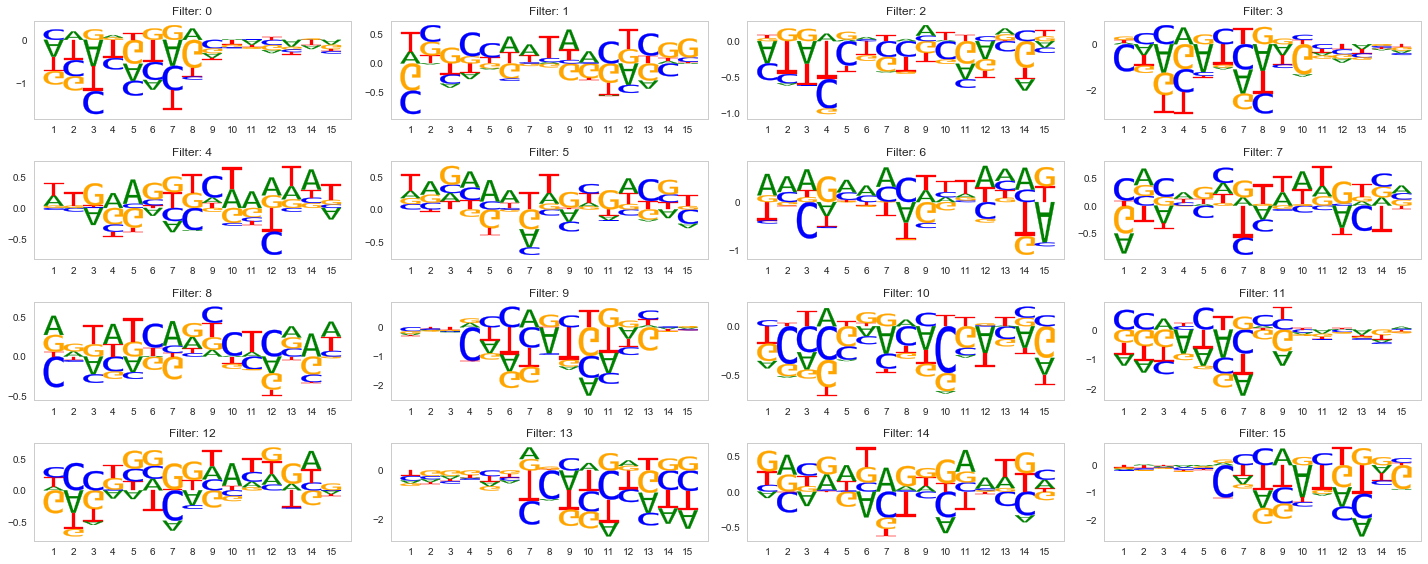

In what other domains/problems might CNNs be useful? Why are CNNs effective in some cases but not others?

In [ ]:
other_cnn_domains = '' #@param {type:"string"}
cnn_efficacy = '' #@param {type:"string"}


---
# Submit your responses
TODO: Setup Airtable<br>
Please run the following cell and then press "Submit" so we can record your responses.

In [ ]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()
try: t7;
except NameError: t7 = time.time()
try: t8;
except NameError: t8 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: output_dim;
except NameError: output_dim = ""

try: overfitting;
except NameError: overfitting = ""

try: regularize_1;
except NameError: regularize_1 = ""

try: regularize_2;
except NameError: regularize_2 = ""

try: augmentation;
except NameError: augmentation = ""

try: back_prop;
except NameError: back_prop = ""

try: other_cnn_domains;
except NameError: other_cnn_domains = ""

try: cnn_efficacy;
except NameError: cnn_efficacy = ""

times = np.array([t0,t1,t2,t3,t4,t5,t6,t7, t8])-t0

fields = {"my_pennkey": my_pennkey,
          "my_pod": my_pod,
          "output_dim":output_dim,
          "overfitting": overfitting,
          "regularize_1":regularize_1,
          "regularize_2": regularize_2,
          "augmentation":augmentation,
          "back_prop":back_prop,
          "other_cnn_domains":other_cnn_domains,
          "cnn_efficacy":cnn_efficacy,
          "cumulative_times": times}

src = "https://airtable.com/embed/shruXwMiIqUw6vC8m?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [ ]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))